# Regularização

Regularização consiste em evitar que ocorra overfit dos dados. Veremos algumas técnicas populares de regularização.

In [1]:
import torch
from torch import nn
from dataset import load_fashion_mnist_small
import train

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

# Dataset fashion MNIST com apenas 1 imagem por classe no conjunto de treinamento
ds_train, ds_valid = load_fashion_mnist_small(n_train=10)


### Treinamento com overfit

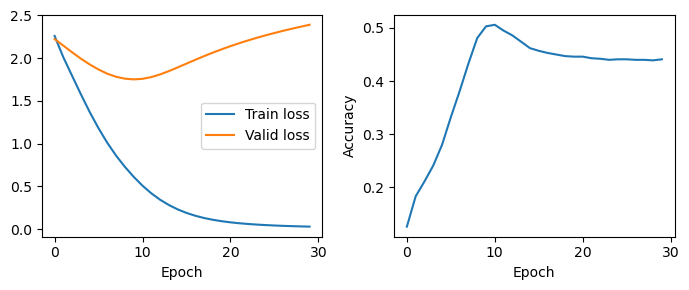

CPU times: total: 40.9 s
Wall time: 11.4 s


In [2]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=10, num_epochs=30, lr=0.1, 
                     weight_decay=0.)
train.plot_log(logger)

### Regularização L2 (weight decay)

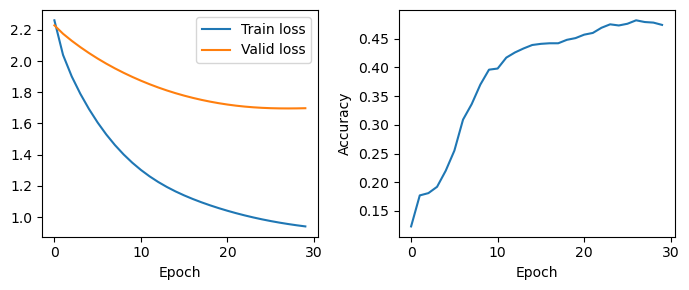

CPU times: total: 40.6 s
Wall time: 11.3 s


In [3]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=10, num_epochs=30, lr=0.1, 
                     weight_decay=0.4)
train.plot_log(logger)

### Efeito de regularização do batch size

Treinamento a rede com um batch size menor também possui um efeito de regularização

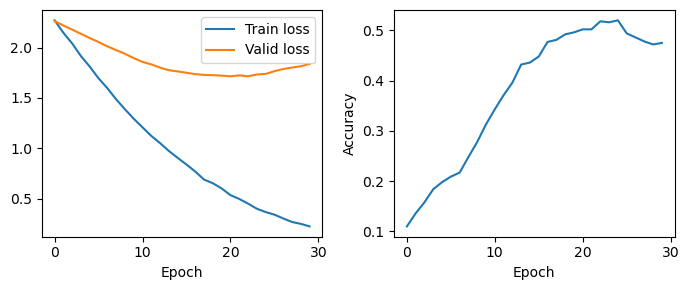

CPU times: total: 31.4 s
Wall time: 13.3 s


In [4]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=2, num_epochs=30, lr=0.01, 
                     weight_decay=0.)
train.plot_log(logger)

### Dropout

#### Entendendo a camada Dropout

A camada dropout remove aleatoriamente alguns valores de entrada. Mas após a remoção o resultado de operações após a camada podem acabar reduzindo de valor. Para evitar isso, a camada reescala os valores.

In [5]:
p = 0.5
drop = nn.Dropout(p)
x = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
y = drop(x)
print(y)

tensor([2., 0., 0., 0., 0., 0.])


In [6]:
# Remove os mesmos valores que a camada Dropout acima
x_drop = x*(y>0)
# Reescala os valores
yc = x_drop/(1-p)
print(yc)

tensor([2., 0., 0., 0., 0., 0.])


In [7]:
drop.eval()
y = drop(x)
print(y)

tensor([1., 2., 3., 4., 5., 6.])


#### Adicionando Dropout ao modelo

É útil adicionar o dropout logo antes da camada de classificação (última camada). A ideia é a seguinte: o dropout evita que a camada de classificação use sempre os mesmos atributos extraídos para fazer a classificação das imagens. 

Dropout possui uma analogia com a técnica de boosting em machine learning. Para a rede ter boa performance, ela precisa ter diversas "subredes" que classificam bem as imagens, pois atributos são aleatoriamente apagados. 

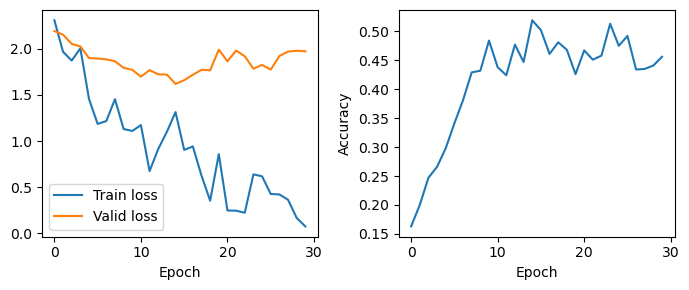

CPU times: total: 42.6 s
Wall time: 12.1 s


In [8]:
%%time
class ModelDrop(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            nn.Dropout(0.5),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layers(x)

torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs=10, num_epochs=30, lr=0.1, 
                     weight_decay=0.)
train.plot_log(logger)

### Aumento de dados

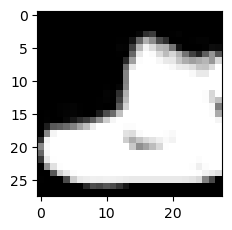

In [12]:
from functools import partial
from dataset import augment_mnist
import matplotlib.pyplot as plt

ds_train.transform = partial(augment_mnist, mean=73., std=81.7)
plt.imshow(ds_train[0][0][0], 'gray')

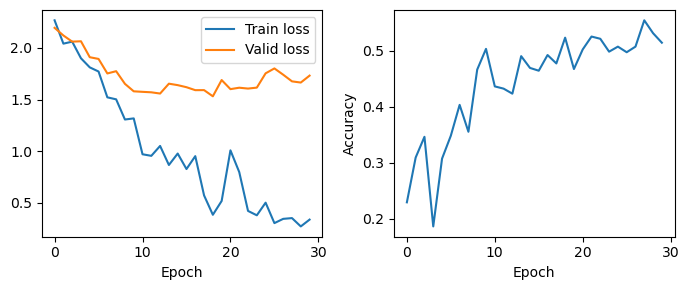

CPU times: total: 42.1 s
Wall time: 11.9 s


In [14]:
%%time
torch.random.manual_seed(0)
model = Model()

logger = train.train(model, ds_train, ds_valid, bs=10, num_epochs=30, lr=0.1, 
                     weight_decay=0.)
train.plot_log(logger)

### Unindo todas as técnicas

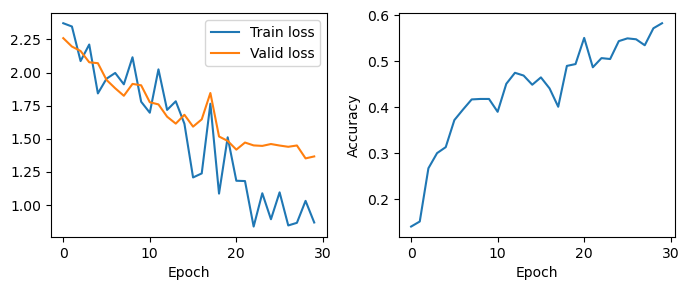

In [16]:
torch.random.manual_seed(0)
model = ModelDrop()

logger = train.train(model, ds_train, ds_valid, bs=2, num_epochs=30, lr=0.02, 
                     weight_decay=0.001)
train.plot_log(logger)